# Neural Net on V4 data

- This is the dataset that has the 9 month gap in texts
- Model achieved great results, but I made a mistake with the shift by dropping rows without text before shifting
- This means each row of resample data was predicting some depression value in the future but it was not uniform

# Imports and Installs

In [2]:
from tensorflow.keras import regularizers

from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation

import matplotlib.pyplot as plt

%matplotlib inline

import numpy as np
from sklearn.model_selection import train_test_split


!pip install tensorflow-hub
#!pip install tensorflow-datasets
import tensorflow_hub as hub

import tensorflow as tf

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

import pandas as pd

# !pip install spacy
# !python -m spacy download en_core_web_sm
# import spacy
# nlp = spacy.load('en_core_web_sm')

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.
Version:  2.2.0
Eager mode:  True
Hub version:  0.9.0
GPU is available


In [ ]:
#defining tokenizer
nlp = spacy.load("en_core_web_sm", disable=['tagger', 'parser', 'ner'])
def tokenizer(text, nlp):

    token_list = []
    doc = nlp(text)
    for token in doc:
        if token.is_stop == False and token.is_punct==False:
            if token.text != ' ':
                token_list.append((token.lemma_).lower())
    str_tokens = ' '.join(token_list)
    return str_tokens

# Data import and shaping

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, stratify=y)

### Building the Model

### Offset of 24

'df: (52758, 13)'

'df: (52758, 13)'

'resampled data: (49115,)'

'less than 100 char: 23789'

'gtrends: (66741, 8)'

'gtrends_with_text: (66741, 8)'

'gtrends_with_text: (66741, 8)'

'depression_target: (33207, 2)'

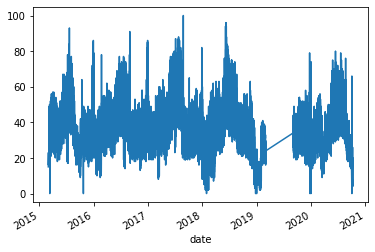

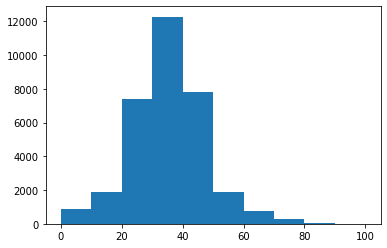

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

'depression_target_after_na_drop: (33183, 3)'

'x_shape: (33183,)'

In [59]:
#reading in gdelt master
df = pd.read_csv('/floyd/home/Capstone/cap_notebooks/data/master_data_set/text_with_tokens_52k.csv')

display(df.shape)

display(df.head())

#extracts date_time from gkgcode
df['date_time']  = df['gkgcode'].apply(lambda x: x[:14])


#create date_time object
df['date_time'] = pd.to_datetime(df['date_time'], format='%Y%m%d%H%M%S')
#set date as index
df.set_index('date_time', inplace=True)

display(df.head())

#resample text data and join text tokens by hour
test_resample = df.resample('h')['text'].agg(lambda column: "".join(column))

display(test_resample.shape)

#check number of strings with less than 100 characters
test_resample.apply(lambda x: len(x) < 100).sum()

#reset index
test_resample = test_resample.reset_index()

### Reading in Google Trends Data

gtrends = pd.read_csv('/floyd/home/Capstone/cap_notebooks/data/google_trends/gtrends_2015-2020_clean.csv')

#set datetime object
gtrends['date'] = pd.to_datetime(gtrends['date'])

display(gtrends.shape)

#merge text and target data frames
gtrends_gdelt = gtrends.merge(test_resample, how='inner', left_on = 'date', right_on = 'date_time' )

#create bool mask for rows with less than 200 characters
gtrends_gdelt['text_bool'] = gtrends_gdelt['text'].apply(lambda x: len(x) < 200)

#keeps rows with text longer than 200 characters. This is the mistake. This should happen after shift
gtrends_gdelt = gtrends_gdelt[gtrends_gdelt['text_bool']==False]

#set date time index
gtrends_gdelt.set_index('date', inplace=True)

#filter df to text and target
depression_target = gtrends_gdelt[['text', 'depression']]

#plot depression counts
depression_target['depression'].plot()

depression_target.describe()

#plot histogram
plt.figure()
plt.hist(depression_target['depression'])
plt.show()

#binarize depression
depression_target['d_search_bin'] = np.where(depression_target['depression'] >= 36, 1, 0)

#shift target by 24 hours
depression_target['d_search_bin'] = depression_target['d_search_bin'].shift(-24)
depression_target.dropna(inplace=True)

depression_target['d_search_bin'].value_counts()
depression_target_x_y = depression_target[['text', 'd_search_bin']]
depression_target_x_y.reset_index(drop=True, inplace=True)

X = depression_target_x_y['text']
y = depression_target_x_y['d_search_bin']

In [54]:
#test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, stratify=y)

In [55]:
#define model
#once again I played with all sorts of variations of this architecture
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(4, activation='relu', kernel_regularizer=regularizers.l2(0.1)))
model.add(tf.keras.layers.Dropout(0.2))
#model.add(tf.keras.layers.Dense(4, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
#model.add(tf.keras.layers.Dropout(0.2))
# model.add(tf.keras.layers.Dense(20, activation='relu', kernel_regularizer=regularizers.l1(0.1)))
# #model.add(tf.keras.layers.Dropout(0.2))
# model.add(tf.keras.layers.Dense(20, activation='relu', kernel_regularizer=regularizers.l1(0.1)))
# #model.add(tf.keras.layers.Dropout(0.2))
# model.add(tf.keras.layers.Dense(20, activation='relu', kernel_regularizer=regularizers.l1(0.1)))
#model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1))


#compile model
model.compile(optimizer='adam',
             loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
             metrics=['accuracy'])

In [56]:
#fit model
history = model.fit(X_train, y_train, epochs=4, verbose=1, validation_data=(X_test, y_test))

Epoch 1/4
726/726 [==============================] - 91s 125ms/step - loss: 0.6984 - accuracy: 0.5211 - val_loss: 0.4503 - val_accuracy: 0.5212
Epoch 2/4
726/726 [==============================] - 91s 125ms/step - loss: 0.4061 - accuracy: 0.8512 - val_loss: 0.3366 - val_accuracy: 0.8718
Epoch 3/4
726/726 [==============================] - 91s 125ms/step - loss: 0.2953 - accuracy: 0.8938 - val_loss: 0.3516 - val_accuracy: 0.8719
Epoch 4/4
726/726 [==============================] - 91s 125ms/step - loss: 0.2466 - accuracy: 0.9130 - val_loss: 0.3700 - val_accuracy: 0.8630
